In [1]:
import torchvision
import copy

from lightly.models.modules import DINOProjectionHead
from lightly.data import LightlyDataset
from lightly.transforms.dino_transform import DINOTransform
from lightly.models.utils import deactivate_requires_grad, update_momentum

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# from dino import DINO

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
batch_size = 16
num_frames = 22

device_ids = [0,1]

In [4]:
import os
import numpy as np
import glob

# list all directories in the current directory
directories = glob.glob("/scratch/pt2295/Dataset_Student/train/video_*")#[d for d in os.listdir('/scratch/pt2295/Dataset_Student/train/') if os.path.isdir(d)]

# create an empty list to store numpy arrays
arrays = {}
# print(directories)

# loop through each directory
ctr=0
for d in directories:
    # construct the path to the mean.npy file
    path_to_mean = os.path.join(d, 'mask.npy')
    # read the mean.npy file as a numpy array
    mean_array = np.load(path_to_mean)
    print(mean_array.shape)
    # append the mean array to the list of arrays
    arrays[ctr]=mean_array
    ctr+=1
    break




(22, 160, 240)


In [5]:
len(directories)

1000

### Dataloader

In [6]:
# import numpy as np

# def one_hot_encoder(mask, num_classes=49):
#     # mask: a numpy array of shape (height, width) with integer class labels
#     # num_classes: an integer representing the number of classes
#     # returns: a numpy array of shape (height, width, num_classes) with one-hot encoded labels
    
#     one_hot = np.zeros((mask.shape[0],mask.shape[1], mask.shape[2], num_classes))
#     for j in range(mask.shape[0]):#for each frame
#         for i in range(num_classes):#for each class
#             one_hot[j,:,:,i] = (mask[j] == i)
#     return one_hot

In [19]:
def one_hot_encoder(mask, num_classes=49):
  # mask: a numpy array of shape (batch, height, width) with integer class labels
  # num_classes: an integer representing the number of classes
  # returns: a numpy array of shape (batch, height, width, num_classes) with one-hot encoded labels
    one_hot = np.eye(num_classes)[mask] # select rows from identity matrix
    return one_hot

In [20]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class MeanNpyDataset(Dataset):
    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.folder_names = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

    def __len__(self):
        return len(self.folder_names)

    def __getitem__(self, idx):
        folder_name = self.folder_names[idx]
       
        path_to_mean = os.path.join(self.directory_path, folder_name, 'mask.npy')

        mean_array = np.load(path_to_mean)
       
        mean_array=one_hot_encoder(mean_array)
        

        return torch.from_numpy(mean_array), folder_name


In [21]:
dataset = MeanNpyDataset('/scratch/jz3395/Dataset_Student/train')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


In [22]:
for batch_idx, (mean_tensor, folder_name) in enumerate(dataloader):
    # do something with the batch of mean tensors and corresponding folder names
#     print(f"Batch {batch_idx}, folder names: {folder_name}")
    print(mean_tensor.shape)
    break

torch.Size([16, 22, 160, 240, 49])


In [23]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output
    
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Softmax()(output)
    

In [24]:
# ckpt = torch.load('convlstm_predictor.pth')
# predictor.load_state_dict(ckpt)

predictor = Seq2Seq(num_channels=49, num_kernels=64, kernel_size=(3, 3), padding=(1, 1), activation="relu", 
                frame_size=(160, 240), num_layers=3)

predictor = nn.DataParallel(predictor.cuda(), device_ids=device_ids).cuda()

optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss(reduction='sum')

In [25]:
len(dataloader)

63

In [27]:
def train_for_11_frames_input():
    num_epochs = 50

    
#     predictor.train()

    t1 = datetime.now()
    ctr=0
    for e in range(num_epochs):

        total_loss = 0

        for i, (mean_tensor, folder_name) in enumerate(dataloader):
            print(i)
            optimizer.zero_grad()
            mean_tensor = mean_tensor.to(torch.float32).permute(0,4,1,2,3)

            
            prev_mean = mean_tensor[:,:,:11,:,:]
            curr_mean=mean_tensor[:,:,11:,:,:]

            pred_mask=predictor(prev_mean)
#             print(pred_mask.shape,"pred mask")

            for i in range(0,10):

                loss = criterion(pred_mask.flatten(),curr_mean[:, :, i, :, :].flatten().to(device))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                next_mask = curr_mean[:, :, i, :, :].to(device)
                next_mask=next_mask.unsqueeze(2)
                pred_mask= predictor(next_mask)
            loss = criterion(pred_mask.flatten(),curr_mean[:, :, -1, :, :].flatten().to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        ctr+=1

        torch.save(predictor.state_dict(), 'p_convlstm_predictor'+str(ctr)+'.pth')

        print(f"\n\nEpoch: {e}, Loss: {total_loss}\n")

    print(f"Training took time: {datetime.now() - t1}")
                
            



In [ ]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
train_for_11_frames_input()


0


/state/partition1/job-32846604/ipykernel_853055/530924047.py:138: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(output)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


Epoch: 0, Loss: 6958473704.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


Epoch: 1, Loss: 6910115408.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


Epoch: 2, Loss: 6905059594.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


Epoch: 3, Loss: 6904537116.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [119]:
# ckpt = torch.load('1vidconvlstm_predictor20.pth')
# predictor.load_state_dict(ckpt)

In [120]:
# predictor.eval()
# for i, (mean_tensor, folder_name) in enumerate(dataloader):
#     for j in range(mean_tensor.shape[0]):
#         print(mean_tensor.shape)
#         prev=mean_tensor[19,11,:,:].unsqueeze(0).unsqueeze(0).unsqueeze(0)
#         print(prev.shape)

#         pred=predictor(prev)
# #         plt.imshow(mean_tensor[3,21,:,:])
# #         print(pred.squeeze().shape)
# #         print('*******')
# #         print(mean_tensor[3,1,:,:].detach().cpu().numpy().squeeze().shape)
# #         plt.hist(mean_tensor[3,1,:,:].flatten().detach().cpu().numpy(), bins=50)
# #         plt.show()
        
        
# #         unique_values, counts = torch.unique(pred.flatten().detach().cpu(), return_counts=True)
# #         for value, count in zip(unique_values, counts):
# #             print(f"{value}: {count}")
# #         plt.imshow(pred.detach().cpu().numpy().squeeze())
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

#         # plot the data on the first subplot
#         ax1.imshow(pred.detach().cpu().numpy().squeeze())
#         ax1.set_title('predicted')

#         # plot the data on the second subplot
#         ax2.imshow(mean_tensor[19,22,:,:])
#         ax2.set_title("GT")

#         # adjust the layout of the subplots
#         fig.tight_layout()

#         # show the plot
#         plt.show()

#         break
#     break

/state/partition1/job-32838218/ipykernel_2104663/530924047.py:138: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(output)


torch.Size([8, 49, 11, 160, 240])
pred mas torch.Size([8, 49, 160, 240])
torch.Size([8, 49, 160, 240])
torch.Size([49, 160, 240])


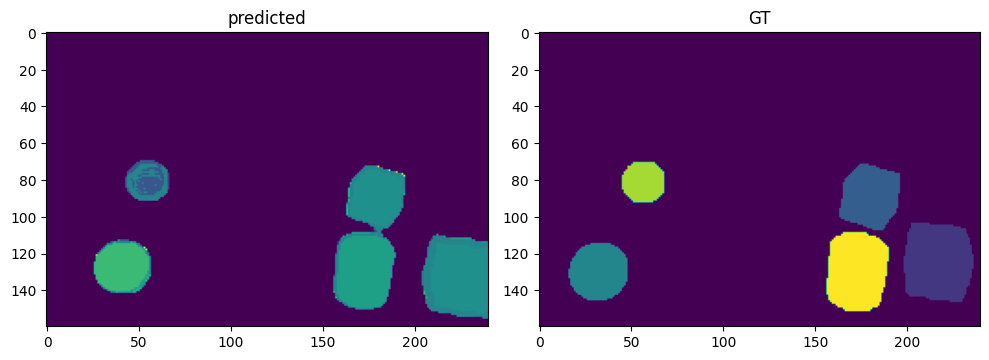

torch.Size([49, 160, 240])


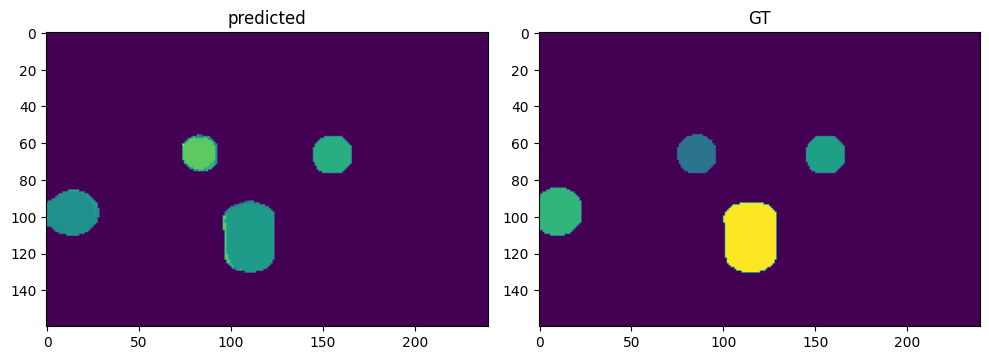

torch.Size([49, 160, 240])


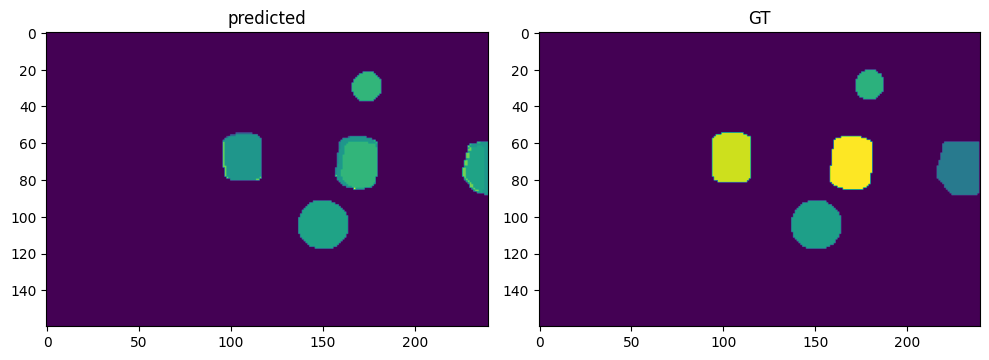

torch.Size([49, 160, 240])


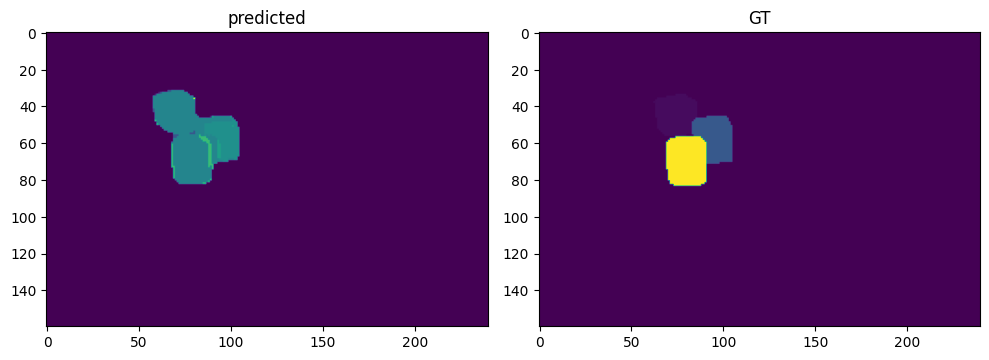

torch.Size([49, 160, 240])


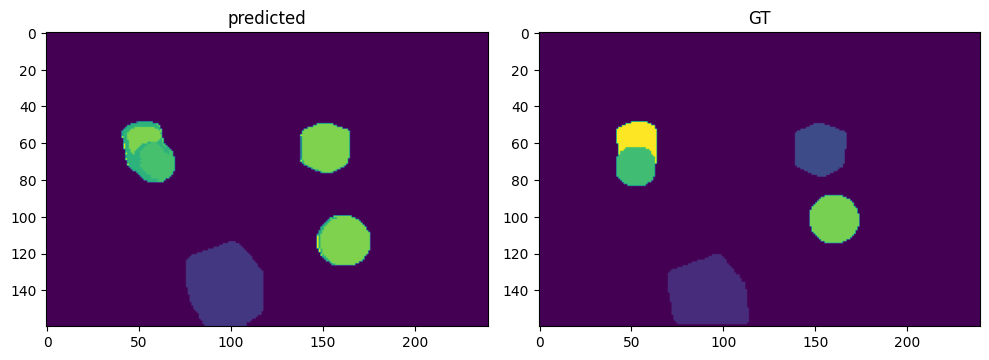

torch.Size([49, 160, 240])


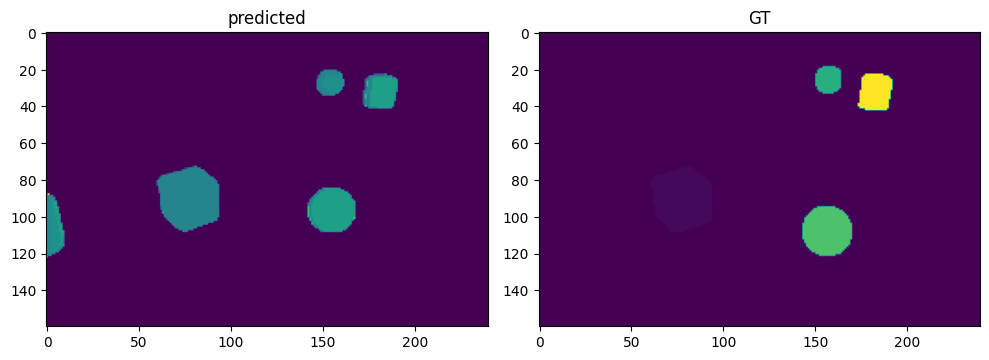

torch.Size([49, 160, 240])


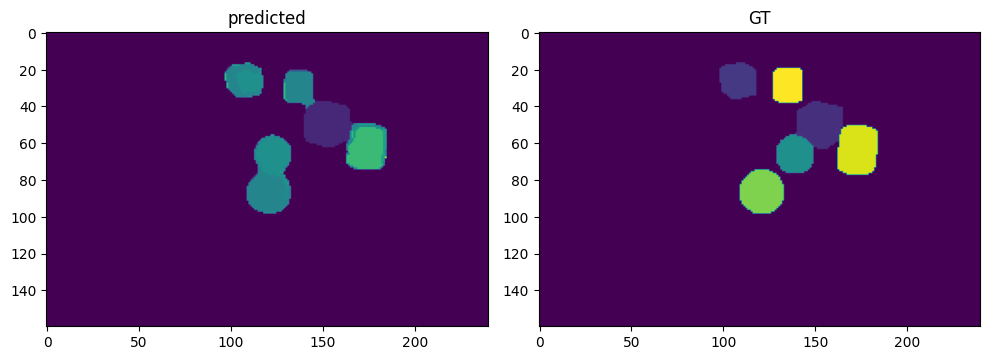

torch.Size([49, 160, 240])


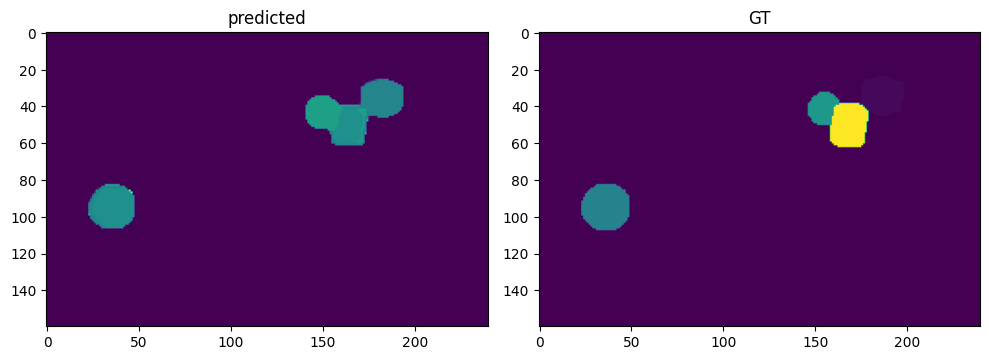

In [19]:
test_dataset = MeanNpyDataset('/scratch/pt2295/Dataset_Student/val/')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

ckpt = torch.load('1vidconvlstm_predictor80.pth')
predictor.load_state_dict(ckpt)
predictor.eval()
sum_iou=0
# for i, (mean_tensor, folder_name) in enumerate(dataloader):
#     for j in range(mean_tensor.shape[0]):
#         ground_truth=mean_tensor[j]#11
#         print(ground_truth.shape)
#         pred_mask=predictor(ground_truth)
#         print(pred_mask.shape)
#         for k in range(0,10):
# #             iou=jaccard(ground_truth[k].flattent(),pred_mask.flatten())
# #             print(iou)
# #             sum_iou+=iou
#             next_mask=ground_truth[k]
#             pred_mask=predictor(next_mask)
            
# print(sum_iou/220000)


for i, (mean_tensor, folder_name) in enumerate(test_dataloader):
    mean_tensor = mean_tensor.to(torch.float32).permute(0,4,1,2,3)
#     mean_tensor=mean_tensor.unsqueeze(1)
    prev_mean = mean_tensor[:,:,:11,:,:]
    curr_mean=mean_tensor[:,:,11:,:,:]
    pred_mask=predictor(prev_mean)
    print(prev_mean.shape)
    print("pred mas",pred_mask.shape)
    for i in range(0,10):

        
        next_mask = curr_mean[:, :, i, :, :].to(device)
        next_mask=next_mask.unsqueeze(2)
        pred_mask= predictor(next_mask)
    print(pred_mask.shape)
    for j in range(pred_mask.shape[0]):   
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        # plot the data on the first subplot
        print(pred_mask[j].shape)
        seg_pred=pred_mask[j].permute(1,2,0).detach().cpu()
        plot_pred=np.argmax(seg_pred, axis=-1)
        
        ax1.imshow(plot_pred.detach().cpu().numpy().squeeze())
        ax1.set_title('predicted')

        # plot the data on the second subplot
        seg_gt=curr_mean[j, :, -1, :, :].permute(1,2,0).detach().cpu()
        plot_gt=np.argmax(seg_gt, axis=-1)
        ax2.imshow(plot_gt.cpu().numpy().squeeze())
        ax2.set_title("GT")

        # adjust the layout of the subplots
        fig.tight_layout()

        
        plt.show()

    break

        
    
    
    
    


In [ ]:
mean_tensor.shape

In [188]:
mean_tensor=mean_tensor.permute(0,2,3,4,1)

In [189]:
segmentation_mask = np.argmax(mean_tensor, axis=-1)

In [190]:
segmentation_mask.shape

torch.Size([1, 22, 160, 240])

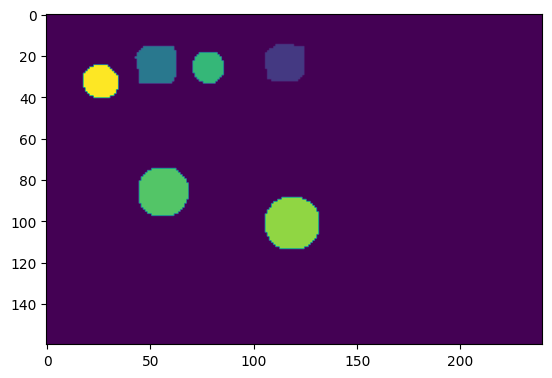

In [191]:
plt.imshow(segmentation_mask[:,21,:,:].squeeze())

In [192]:
pred_mask.permute(0,2,3,1).shape

torch.Size([1, 160, 240, 49])

In [193]:
p_pred=pred_mask.permute(0,2,3,1).detach().cpu()
seg_pred=np.argmax(p_pred, axis=-1)

In [194]:
seg_pred.shape

torch.Size([1, 160, 240])

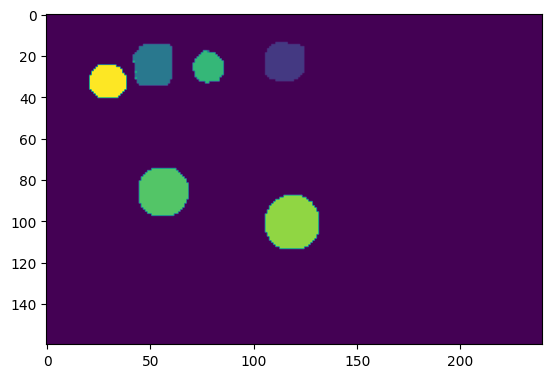

In [195]:
plt.imshow(seg_pred.squeeze())

In [76]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)

NameError: name 'torchmetrics' is not defined

In [22]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 31.3 MB/s eta 0:00:0000:0100:01


torch.Size([1, 1, 160, 240])
torch.Size([1, 1, 160, 240])


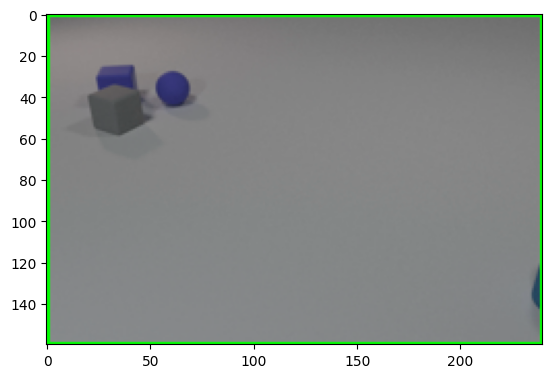

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the output segmentation map obtained from the semantic segmentation model
# output = np.load('output.npy')

# Convert the output segmentation map to a tensor and normalize it
print(output.shape)
output = torch.from_numpy(output.detach().cpu().numpy())
print(output.shape)
output = F.interpolate(output, size=(160,240), mode='bicubic', align_corners=False)
output = F.softmax(output, dim=1)

# Find the class with the highest probability for each pixel
segmentation_map = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Find the contours of each class in the segmentation map
contours = []
num_classes=49
for i in range(num_classes):
    binary_mask = (segmentation_map == i).astype(np.uint8)
    cnts, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours.append(cnts)

# Draw bounding boxes around the objects of interest for each class
boxes = []
img = cv2.imread('/scratch/pt2295/Dataset_Student/val/video_1031/image_21.png')
for i, cnts in enumerate(contours):
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x + w, y + h, i])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Visualize the result
plt.imshow(img)
plt.show()

In [8]:
# temp = torch.randn(1, 6, 21, 601, 601)
# tout = predictor(temp)
def threshold(tensor,thresh):
    return torch.where(tensor < thresh, torch.tensor(0.), torch.tensor(1.));

In [55]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
def for_each_img(attn,w_featmap,h_featmap):
#     print(attn.shape)
    attn=attn.unsqueeze(0)
   
    nh = attn.shape[1] # number of head

    # we keep only the output patch attention
    attn = attn[0, :, 0, 1:].reshape(nh, -1)


    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attn)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
#     print(w_featmap, h_featmap,th_attn.shape)
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

    attn = attn.reshape(nh, w_featmap, h_featmap)
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

    # save attn heatmaps
    os.makedirs('output/', exist_ok=True)

    # Saving only last attention layer
    fname = os.path.join('output/',  "temp.png")

    plt.imsave(
        fname=fname,
        arr=sum(attn[i] * 1/attn.shape[0] for i in range(attn.shape[0])),
        cmap="inferno",
        format="jpg"
    )
    img = Image.open('/scratch/pt2295/predictor/output/temp.png')

    # convert the image to grayscale using torchvision.transforms
    gray_transform = transforms.Grayscale()
    gray_img = gray_transform(img)
    t=transforms.ToTensor()(gray_img)
    p=threshold(t,att_thresh)

    
    return p

  

In [56]:
def transform_att(tensor,w,h):
#     print(tensor.shape)
   
    temp=[]
    for i in range(tensor.shape[0]):
        temp.append(for_each_img(tensor[i],w,h))
    return torch.cat(temp,dim=0)
    
    

In [57]:
att_thresh=0.4

In [58]:
from datetime import datetime
def threshold(tensor,thresh):
    return torch.where(tensor < thresh, torch.tensor(0.), torch.tensor(1.));
def train_for_11_frames_input():
    num_epochs = 50

    encoder.eval()
    predictor.train()

    t1 = datetime.now()
    ctr=0
    for e in range(num_epochs):

        total_loss = 0

        for i, (batch, _, _) in enumerate(dataloader):

            optimizer.zero_grad()
            

            print(i, end=", ")
            w, h = batch.shape[1] - batch.shape[1] % 8, batch.shape[2] - batch.shape[2] % 8
            # img = img[:, :w, :h].unsqueeze(0)

            w_featmap = batch.shape[-2] // 8
            h_featmap = batch.shape[-1] // 8   
            with torch.no_grad():
                attentions = encoder.module.student_backbone.module.get_last_selfattention(batch.cuda())
            attentions=transform_att(attentions,w_featmap,h_featmap)
            print(attentions.shape)
            attentions=attentions.unsqueeze(1)

            
            
          
            
            N, C, H, W = attentions.shape
        
            
            B = int(N // num_frames)
            
            attentions = attentions.view(B, num_frames, C, H, W)
           

            prev_attns = attentions[:, :11].permute(0,2,1,3,4)
         
            curr_attns = attentions[:, 11:]
   
            pred_attn= predictor(prev_attns)


            for i in range(0, 10):

                loss = criterion(pred_attn, curr_attns[:,i].to(device))
                

                loss.backward(retain_graph=True)
                optimizer.step()

                total_loss += loss.item()

                next_attn = curr_attns[:,i].unsqueeze(1).permute(0,2,1,3,4)

                pred_attn= predictor(next_attn.to(device))


            loss = criterion(pred_attn, curr_attns[:,-1].to(device))
            print(pred_attn.shape,"predic shape",curr_attns[:,-1].shape)
            visualise(threshold(pred_attn[0,:,:,:],att_thresh),is_pred=True)
            visualise(curr_attns[:,-1][0,:,:,:].to(device))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        ctr+=1

        torch.save(predictor.state_dict(), 'convlstm_predictor'+str(ctr)+'.pth')

        print(f"\n\nEpoch: {e}, Loss: {total_loss}\n")

    print(f"Training took time: {datetime.now() - t1}")




In [59]:
# # train_for_21_frames_input()
# 16, 1, 10, 64, 64

In [60]:
import numpy as np
train_for_11_frames_input()

0, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
1, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
2, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])


Epoch: 0, Loss: 1416754.619140625

0, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
1, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
2, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])


Epoch: 1, Loss: 1208356.166015625

0, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
1, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])
2, torch.Size([88, 160, 240])
torch.Size([4, 1, 160, 240]) predic shape torch.Size([4, 1, 160, 240])


Epoch: 2, Loss:

In [ ]:
predictor.module.first_layer.module.convLSTMcell.module

In [94]:
import os
import torch.nn as nn
import matplotlib.pyplot as plt

def my_save_image(attn, pred, ctr,is_attn=False):

    print(attn.shape)
    nh = attn.shape[1] # number of head

    # we keep only the output patch attention
    attn = attn[0, :, 0, 1:].reshape(nh, -1)


    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attn)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    print(w_featmap, h_featmap,th_attn.shape)
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

    attn = attn.reshape(nh, w_featmap, h_featmap)
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

    # save attn heatmaps
    os.makedirs('output/', exist_ok=True)

    # Saving only last attention layer
    fname = os.path.join('output/', "attn-" + str(ctr) + pred + ".png")

    plt.imsave(
        fname=fname,
        arr=sum(attn[i] * 1/attn.shape[0] for i in range(attn.shape[0])),
        cmap="inferno",
        format="jpg"
    )
    print(f"{fname} saved.")

In [43]:
def visualise(p,is_pred=False):
    np_array = p.detach().cpu().numpy().reshape(160, 240)

    # convert numpy array to PIL Image and convert to grayscale
    pil_image = Image.fromarray(np.uint8(np_array * 255))
    gray_image = pil_image.convert('L')

    # save grayscale PIL Image to disk
    if(is_pred):
        gray_image.save('/scratch/pt2295/predictor/output/gray_image_pred.png')
    else:
        gray_image.save('/scratch/pt2295/predictor/output/gray_image_att.png')

In [26]:
# from torchvision.utils import save_image
# torch.set_printoptions(profile="full")
ckpt = torch.load('convlstm_predictor49.pth')
predictor.load_state_dict(ckpt)

test_dataset = LightlyDataset(input_dir="/scratch/pt2295/proj/test", transform=transform)
test_dataset.transform = torchvision.transforms.ToTensor()


test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=num_frames,   # batch size 1 for inference
    shuffle=False,  # don't shuffle data during inference
)

encoder.eval()
predictor.eval()

correct = 0
total = 0

ctr = 0
for img, label, fnames in test_dataloader:

    with torch.no_grad():
        print(fnames)
        img = img.cuda()
        print(img.shape)
        w, h = img.shape[1] - img.shape[1] % 8, img.shape[2] - img.shape[2] % 8
        # img = img[:, :w, :h].unsqueeze(0)

        w_featmap = img.shape[-2] // 8
        h_featmap = img.shape[-1] // 8

        attentions = encoder.module.student_backbone.module.get_last_selfattention(img.cuda())
        temp=attentions
        attentions=transform_att(attentions,w_featmap,h_featmap)
        attentions=attentions.unsqueeze(1)


        N, C, H, W = attentions.shape

        prev_attns = attentions[:11].view(1, 11, C, H, W).permute(0, 2, 1, 3, 4)


        pred_attn = predictor(prev_attns)

        for i in range(11, 21):

            next_attn = attentions[i].view(1, 1, C, H, W).permute(0,2,1,3,4)

            pred_attn= predictor(next_attn)
            

            

        correct += torch.sum(pred_attn.view(1, -1) == attentions[-1].view(1, -1).to(device))

        total += 6*601*601

        my_save_image(attentions[-1], "_3321_o", ctr)
        my_save_image(pred_attn, "_3321_p", ctr)
        print("##############")
#         print(attentions[-1])
        print("*************")
#         print(pred_attn)
        
        print("how many equal",(threshold(pred_attn,0.2).cuda() == attentions[-1].squeeze(0).cuda()).sum().item())
        print("1 in attention",(attentions[-1] == 1).sum().item())
        print("how many in pred 1",(threshold(pred_attn,0.2) == 1).sum().item())
        print("mae")

        ctr += 1
        

print(f"Accuracy: {correct/total}")

('video_2005/image_0.png', 'video_2005/image_1.png', 'video_2005/image_10.png', 'video_2005/image_11.png', 'video_2005/image_12.png', 'video_2005/image_13.png', 'video_2005/image_14.png', 'video_2005/image_15.png', 'video_2005/image_16.png', 'video_2005/image_17.png', 'video_2005/image_18.png', 'video_2005/image_19.png', 'video_2005/image_2.png', 'video_2005/image_20.png', 'video_2005/image_21.png', 'video_2005/image_3.png', 'video_2005/image_4.png', 'video_2005/image_5.png', 'video_2005/image_6.png', 'video_2005/image_7.png', 'video_2005/image_8.png', 'video_2005/image_9.png')
torch.Size([22, 3, 160, 240])
torch.Size([1, 160, 240])


IndexError: too many indices for tensor of dimension 3

In [19]:
# import torch
# import torchvision.utils as vutils
# vutils.save_image(threshold(pred_attn), 'my_predsttn.png', normalize=True, range=(0, 255))
# vutils.save_image(attentions[-1].squeeze(0), 'my_attn.png', normalize=True, range=(0, 255))


TypeError: threshold() missing 1 required positional argument: 'thresh'

In [20]:
vutils.save_image(temp[-1], 'my_tttttempattn.png', normalize=True, range=(0, 1), nrow=1, pad_value=1)

In [116]:
temp[-1].shape

torch.Size([6, 601, 601])

In [117]:
temp[-1].unsqueeze(0).shape

torch.Size([1, 6, 601, 601])

In [31]:
my_save_image(temp[-1].unsqueeze(0),"blah","2")

torch.Size([1, 6, 601, 601])
20 30 torch.Size([6, 600])
output/attn-2blah.png saved.


In [23]:
# torch.abs(threshold(pred_attn) - attentions[-1].squeeze(0))

In [66]:
# attentions[-1]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [58]:
pred_attn.squeeze(0).shape

torch.Size([1, 601, 601])

In [115]:
pred_attn.shape

torch.Size([1, 1, 601, 601])

In [53]:
threshold(pred_attn[:,:,0,:])

tensor([[[1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [19]:
# torch.sigmoid(pred_attn[0,0,0])

In [ ]:
loss = criterion(pred_attn, torch.sigmoid(attentions[-1].unsqueeze(0)).to(device))
loss.item()

In [ ]:
pred_attn.shape, attentions[-1].shape

In [ ]:
datetime.now() - t1

In [ ]:
9714 / 60 / 60

In [ ]:
total_loss

In [17]:
import torch
import torchvision.utils as vutils

# create a grayscale tensor
x = torch.rand(1, 601, 601)

# save tensor as a grayscale image
vutils.save_image(x, 'my_tensor_image.png', normalize=True, range=(0, 1), nrow=1, pad_value=1)


In [18]:
x

tensor([[[0.2411, 0.2728, 0.8088,  ..., 0.6151, 0.9547, 0.3072],
         [0.1555, 0.7170, 0.3933,  ..., 0.0553, 0.2734, 0.1360],
         [0.7500, 0.2112, 0.4023,  ..., 0.9949, 0.9845, 0.6920],
         ...,
         [0.7599, 0.8041, 0.5807,  ..., 0.1659, 0.5261, 0.4573],
         [0.2977, 0.5336, 0.0671,  ..., 0.0119, 0.2761, 0.8062],
         [0.7940, 0.6168, 0.3275,  ..., 0.7168, 0.6432, 0.7858]]])

In [34]:
import torch
import torchvision.transforms as transforms
from PIL import Image


# define the image file path
img_file = '/scratch/pt2295/predictor/output/attn-2blah.png'

# create a transformation to convert the image to a tensor
transform = transforms.ToTensor()

# load the image as a tensor
img_tensor = transform(Image.open(img_file))

# print the tensor shape
print(img_tensor.shape)


torch.Size([3, 160, 240])


In [35]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# load the image as a PIL Image object
img = Image.open('/scratch/pt2295/predictor/output/attn-2blah.png')

# convert the image to grayscale using torchvision.transforms
gray_transform = transforms.Grayscale()
gray_img = gray_transform(img)

# save the grayscale image as a file
gray_img.save('/scratch/pt2295/predictor/output/att2blah_gray.jpg')


In [51]:
t=transforms.ToTensor()(gray_img)
torch.sum(t > 0.2)

tensor(2688)

In [160]:
t.shape

torch.Size([1, 160, 240])

In [58]:
p=threshold(t,0.2)
import numpy as np

In [59]:
np_array = p.numpy().reshape(160, 240)

# convert numpy array to PIL Image and convert to grayscale
pil_image = Image.fromarray(np.uint8(np_array * 255))
gray_image = pil_image.convert('L')

# save grayscale PIL Image to disk
gray_image.save('/scratch/pt2295/predictor/output/grayscale_image.png')

In [56]:
p.shape

torch.Size([1, 160, 240])

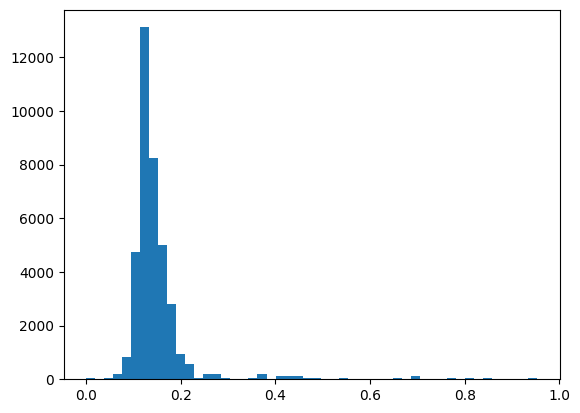

In [49]:
plt.hist(t.flatten().numpy(), bins=50)
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# load the image as a PIL Image object
img = Image.open('/scratch/pt2295/predictor/output/attn-2blah.png')

# convert the image to grayscale using torchvision.transforms
gray_transform = transforms.Grayscale()

gray_img = gray_transform(img)

# save the grayscale image as a file
gray_img.save('/scratch/pt2295/predictor/output/ttatt2blah_gray.jpg')